In [ ]:
from google.colab import drive
from keras.datasets import mnist
import random
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
def get_MNIST_data(num_training=58000, num_validation=2000, num_test=1000, num_dev=500):
    try:
       del X_train, y_train
       del X_test, y_test
       print('Clear previously loaded data.')
    except:
       pass

    (X_train, y_train), (X_test, y_test) = mnist.load_data()
    
    # subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]
    mask = np.random.choice(num_training, num_dev, replace=False)
    X_dev = X_train[mask]
    y_dev = y_train[mask]
    
    # Preprocessing: reshape the image data into rows
    X_train = np.reshape(X_train, (X_train.shape[0], -1))
    X_val = np.reshape(X_val, (X_val.shape[0], -1))
    X_test = np.reshape(X_test, (X_test.shape[0], -1))
    X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))
    
    # Normalize the data: subtract the mean image
    mean_image = np.mean(X_train, axis = 0)
    X_train = X_train - mean_image
    X_val = X_val - mean_image
    X_test = X_test - mean_image
    X_dev = X_dev - mean_image
    
    # add bias dimension and transform into columns
    X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
    X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
    X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
    X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])
    
    return X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev


# Invoke the above function to get our data.
X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev = get_MNIST_data()
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)
print('dev data shape: ', X_dev.shape)
print('dev labels shape: ', y_dev.shape)

Train data shape:  (58000, 785)
Train labels shape:  (58000,)
Validation data shape:  (2000, 785)
Validation labels shape:  (2000,)
Test data shape:  (1000, 785)
Test labels shape:  (1000,)
dev data shape:  (500, 785)
dev labels shape:  (500,)


## Softmax Classifier

In [ ]:
from builtins import range
import numpy as np
from random import shuffle
from past.builtins import xrange

def softmax_loss_naive(W, X, y, reg):
    loss = 0.0
    dW = np.zeros_like(W)

    num_train = X.shape[0]
    num_classes = W.shape[1]
   
    for i in range(num_train):
        scores = X[i].dot(W)
        scores -= np.max(scores)
        
        sum_exp_s = np.sum(np.exp(scores))
        exp_s = np.exp(scores[y[i]])
        
        softmax = exp_s / sum_exp_s
        loss += -np.log(softmax)
        
        for j in range(num_classes):
            dW[:,j] += np.exp(scores[j])/sum_exp_s * X[i] 
        dW[:,y[i]] -= (sum_exp_s - exp_s) / sum_exp_s * X[i]
        
    loss /= num_train
    dW /= num_train
    
    loss += reg*np.sum(W*W)
    dW += reg*2*W

    return loss, dW


def softmax_loss_vectorized(W, X, y, reg):
    loss = 0.0
    dW = np.zeros_like(W)

    num_train = X.shape[0]
    scores = X.dot(W)
    
    softmax = np.exp(scores)/np.exp(scores).sum(axis=1, keepdims=True)
    loss = np.sum(-np.log(softmax[np.arange(num_train), y]))
    
    softmax[np.arange(num_train), y] -= 1
    dW = X.T.dot(softmax)
    
    loss /= num_train
    dW /= num_train
    
    loss += reg*np.sum(W*W)
    dW += reg*2*W

    return loss, dW

## Gradient check

In [ ]:
from __future__ import print_function
from builtins import range
from past.builtins import xrange

import numpy as np
from random import randrange

def eval_numerical_gradient(f, x, verbose=True, h=0.00001):
    fx = f(x) # evaluate function value at original point
    grad = np.zeros_like(x)
    # iterate over all indexes in x
    it = np.nditer(x, flags=['multi_index'], op_flags=['readwrite'])
    while not it.finished:

        # evaluate function at x+h
        ix = it.multi_index
        oldval = x[ix]
        x[ix] = oldval + h # increment by h
        fxph = f(x) # evalute f(x + h)
        x[ix] = oldval - h
        fxmh = f(x) # evaluate f(x - h)
        x[ix] = oldval # restore

        grad[ix] = (fxph - fxmh) / (2 * h)
        if verbose:
            print(ix, grad[ix])
        it.iternext() 

    return grad


def eval_numerical_gradient_array(f, x, df, h=1e-5):
    grad = np.zeros_like(x)
    it = np.nditer(x, flags=['multi_index'], op_flags=['readwrite'])
    while not it.finished:
        ix = it.multi_index

        oldval = x[ix]
        x[ix] = oldval + h
        pos = f(x).copy()
        x[ix] = oldval - h
        neg = f(x).copy()
        x[ix] = oldval

        grad[ix] = np.sum((pos - neg) * df) / (2 * h)
        it.iternext()
    return grad


def eval_numerical_gradient_blobs(f, inputs, output, h=1e-5):
    numeric_diffs = []
    for input_blob in inputs:
        diff = np.zeros_like(input_blob.diffs)
        it = np.nditer(input_blob.vals, flags=['multi_index'],
                       op_flags=['readwrite'])
        while not it.finished:
            idx = it.multi_index
            orig = input_blob.vals[idx]

            input_blob.vals[idx] = orig + h
            f(*(inputs + (output,)))
            pos = np.copy(output.vals)
            input_blob.vals[idx] = orig - h
            f(*(inputs + (output,)))
            neg = np.copy(output.vals)
            input_blob.vals[idx] = orig

            diff[idx] = np.sum((pos - neg) * output.diffs) / (2.0 * h)

            it.iternext()
        numeric_diffs.append(diff)
    return numeric_diffs


def eval_numerical_gradient_net(net, inputs, output, h=1e-5):
    return eval_numerical_gradient_blobs(lambda *args: net.forward(),
                inputs, output, h=h)


def grad_check_sparse(f, x, analytic_grad, num_checks=10, h=1e-5):
    for i in range(num_checks):
        ix = tuple([randrange(m) for m in x.shape])

        oldval = x[ix]
        x[ix] = oldval + h # increment by h
        fxph = f(x) # evaluate f(x + h)
        x[ix] = oldval - h # increment by h
        fxmh = f(x) # evaluate f(x - h)
        x[ix] = oldval # reset

        grad_numerical = (fxph - fxmh) / (2 * h)
        grad_analytic = analytic_grad[ix]
        rel_error = (abs(grad_numerical - grad_analytic) /
                    (abs(grad_numerical) + abs(grad_analytic)))
        print('numerical: %f analytic: %f, relative error: %e'
              %(grad_numerical, grad_analytic, rel_error))

## SVM

In [ ]:
from builtins import range
import numpy as np
from random import shuffle
from past.builtins import xrange

def svm_loss_naive(W, X, y, reg):
    dW = np.zeros(W.shape)

    num_classes = W.shape[1]
    num_train = X.shape[0]
    loss = 0.0
    for i in range(num_train):
        scores = X[i].dot(W)
        correct_class_score = scores[y[i]]
        for j in range(num_classes):
            if j == y[i]:
                continue
            margin = scores[j] - correct_class_score + 1
            if margin > 0:
                loss += margin
                dW[:, j] += X[i, :]
                dW[:, y[i]] -= X[i, :]

    loss /= num_train
    dW /= num_train

    loss += reg * np.sum(W * W)
    dW += 2*reg*W
    
    return loss, dW



def svm_loss_vectorized(W, X, y, reg):
    loss = 0.0
    dW = np.zeros(W.shape)

    scores = np.matmul(X,W)
    correct_class_score = scores[range(X.shape[0]),y]
    delta = np.ones(scores.shape)
    delta[range(X.shape[0]),y] = 0
    
    margin = np.maximum(0, scores - np.reshape(correct_class_score, (correct_class_score.shape[0],1)) + delta)
    loss += np.mean(np.sum(margin, axis=1))
    loss += reg * np.sum(W*W)

    margin_valid = np.zeros(margin.shape)
    margin_valid [margin>0] = 1
    margin_valid [range(X.shape[0]), y] = -np.sum(margin_valid, axis=1)
    
    dW = np.matmul(X.T, margin_valid) / X.shape[0]
    dW += 2*reg*W

    return loss, dW

## Linear classifier

In [ ]:
from __future__ import print_function

from builtins import range
from builtins import object
import numpy as np
from past.builtins import xrange


class LinearClassifier(object):

    def __init__(self):
        self.W = None

    def train(self, X, y, learning_rate, reg, num_iters,
              batch_size=200, verbose=False):
        num_train, dim = X.shape
        num_classes = np.max(y) + 1 
        if self.W is None:
            self.W = 0.001 * np.random.randn(dim, num_classes)

        loss_history = []
        for it in range(num_iters):
            X_batch = None
            y_batch = None

            idxs = np.random.choice(num_train, batch_size)
            X_batch = X[idxs]
            y_batch = y[idxs]

            loss, grad = self.loss(X_batch, y_batch, reg)
            loss_history.append(loss)

            self.W -= learning_rate * grad

            if verbose and it % 100 == 0:
                print('iteration %d / %d: loss %f' % (it, num_iters, loss))

        return loss_history

    def predict(self, X):
        y_pred = np.zeros(X.shape[0])

        y_pred = np.argmax(np.dot(X, self.W), axis=1)

        return y_pred

    def loss(self, X_batch, y_batch, reg):
        pass

class LinearSVM(LinearClassifier):
    def loss(self, X_batch, y_batch, reg):
        return svm_loss_vectorized(self.W, X_batch, y_batch, reg)


class Softmax(LinearClassifier):
    def loss(self, X_batch, y_batch, reg):
        return softmax_loss_vectorized(self.W, X_batch, y_batch, reg)

In [ ]:
import time

W = np.random.randn(785, 10) * 0.0001
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

print('loss: %f' % loss)
print('sanity check: %f' % (-np.log(0.1)))

loss: 2.303713
sanity check: 2.302585


In [ ]:
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

loss, grad = softmax_loss_naive(W, X_dev, y_dev, 5e1)
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 5e1)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

numerical: 0.000154 analytic: -0.001078, relative error: 1.000000e+00
numerical: -0.000059 analytic: -0.000160, relative error: 4.617839e-01
numerical: 0.001349 analytic: -0.000488, relative error: 1.000000e+00
numerical: 5.324989 analytic: 4.823073, relative error: 4.945931e-02
numerical: 0.638372 analytic: 0.572059, relative error: 5.478520e-02
numerical: -11.030769 analytic: -10.006138, relative error: 4.870639e-02
numerical: 0.698545 analytic: 0.631052, relative error: 5.076211e-02
numerical: 0.000000 analytic: 0.000000, relative error: nan


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:94: RuntimeWarning: invalid value encountered in double_scalars


numerical: -0.028250 analytic: -0.029046, relative error: 1.390816e-02
numerical: 5.044436 analytic: 4.517594, relative error: 5.509725e-02
numerical: -11.154828 analytic: -10.059001, relative error: 5.165628e-02
numerical: 0.865749 analytic: 0.902951, relative error: 2.103345e-02
numerical: 0.003237 analytic: 0.002165, relative error: 1.983571e-01
numerical: 0.002983 analytic: 0.002906, relative error: 1.307247e-02
numerical: 4.986414 analytic: 4.402107, relative error: 6.223632e-02
numerical: 0.035699 analytic: 0.024253, relative error: 1.909303e-01
numerical: 0.412319 analytic: 0.353632, relative error: 7.661990e-02
numerical: -6.984979 analytic: -6.359443, relative error: 4.687617e-02
numerical: 0.404922 analytic: 0.375191, relative error: 3.811102e-02
numerical: 0.117672 analytic: 0.093005, relative error: 1.170841e-01


In [ ]:
tic = time.time()
loss_naive, grad_naive = softmax_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('naive loss: %e computed in %fs' % (loss_naive, toc - tic))

tic = time.time()
loss_vectorized, grad_vectorized = softmax_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic))

grad_difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print('Loss difference: %f' % np.abs(loss_naive - loss_vectorized))
print('Gradient difference: %f' % grad_difference)

naive loss: 2.303713e+00 computed in 0.063890s
vectorized loss: 2.303713e+00 computed in 0.003797s
Loss difference: 0.000000
Gradient difference: 28.702420


In [ ]:
results = {}
best_val = -1
best_softmax = None

learning_rates = [1e-5, 1e-6]
regularization_strengths = [0, 1]

for lr in learning_rates:
  for reg in regularization_strengths:
    softmax = Softmax()
    loss = softmax.train(X_train, y_train, learning_rate=lr, reg=reg, 
                         num_iters=1500, verbose=False)
    acc_train = np.mean(y_train == softmax.predict(X_train))
    acc_val = np.mean(y_val == softmax.predict(X_val))

    results[(lr, reg)] = (acc_train, acc_val)

    if acc_val > best_val :
      best_val = acc_val
      best_softmax = softmax
      best_lr = lr
      best_reg = reg

for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)
print('best parameters for best validation accuracy> learning rate:',best_lr,' regularization strengths:',best_reg)

lr 1.000000e-06 reg 0.000000e+00 train accuracy: 0.878983 val accuracy: 0.919000
lr 1.000000e-06 reg 1.000000e+00 train accuracy: 0.881603 val accuracy: 0.928000
lr 1.000000e-05 reg 0.000000e+00 train accuracy: 0.914155 val accuracy: 0.943500
lr 1.000000e-05 reg 1.000000e+00 train accuracy: 0.914793 val accuracy: 0.945500
best validation accuracy achieved during cross-validation: 0.945500
best parameters for best validation accuracy> learning rate: 1e-05  regularization strengths: 1


In [ ]:
y_test_pred = best_softmax.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print('softmax on raw pixels final test set accuracy: %f' % (test_accuracy, ))

softmax on raw pixels final test set accuracy: 0.909000


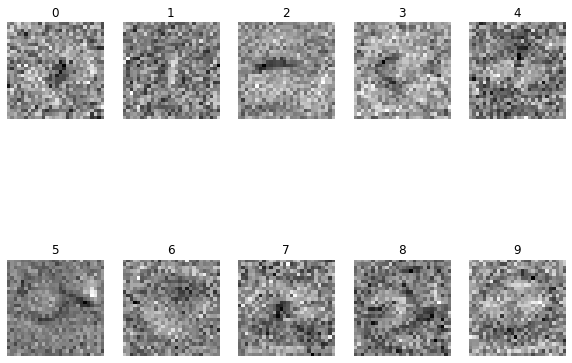

In [ ]:
w = best_softmax.W[:-1,:]
w = w.reshape(28, 28, 10)

w_min, w_max = np.min(w), np.max(w)

classes = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
for i in range(10):
    plt.subplot(2, 5, i + 1)
    
    wimg = 255.0 * (w[:, :, i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])

---
# IMPORTANT

This is the end of this question. Please do the following:

1. Click `File -> Save` to make sure the latest checkpoint of this notebook is saved to your Drive.
2. Execute the cell below to download the modified `.py` files back to your drive.

In [ ]:
import os

FOLDER_TO_SAVE = os.path.join('drive/My Drive/', FOLDERNAME)
FILES_TO_SAVE = ['cs231n/classifiers/softmax.py']

for files in FILES_TO_SAVE:
  with open(os.path.join(FOLDER_TO_SAVE, '/'.join(files.split('/')[1:])), 'w') as f:
    f.write(''.join(open(files).readlines()))